In [1]:
!pip install requests pandas psycopg2 sqlalchemy schedule

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   --------- ------------------------------ 0.5/2.1 MB 5.6 MB/s eta 0:00:01
   ------------------------ --------------- 1.3/2.1 MB 4.5 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 4.2 MB/s eta 0:00:00


In [43]:
import requests
import pandas as pd
def fetch_stock_data():
    # Your API Key (Replace 'YOUR_API_KEY' with the actual key from Alpha Vantage)
    API_KEY = "9O2H41A7VIY1QDHC"
    
    # Choose a stock symbol (e.g., Apple - AAPL)
    stock_symbol = "AAPL"
    
    # Alpha Vantage API endpoint
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={stock_symbol}&interval=5min&apikey={API_KEY}"
    
    # Fetch data
    response = requests.get(url)
    data = response.json()
    
    # Display raw data
    print(data)
    return data


In [44]:
#data cleaning
def clean_stock_data(data):
    time_series = data['Time Series (5min)']
    df = pd.DataFrame.from_dict(time_series, orient='index')
    df.columns = ['open','high','low','close','volume']
    df.index = pd.to_datetime(df.index)
    
    #display the cleaned dataframe
    print(df.head())
    return df
#this will create a dataframe having columns for open, high, low, close prices, and volume, and the index will be the timestamps

In [45]:
#storing in postgresql
import psycopg2
def load_data_to_postgres(df):
    dbname = 'stock_market_database'
    user = 'postgres'
    password = '0000'
    host = 'localhost'
    conn = psycopg2.connect(dbname=dbname, user=user,password=password, host=host)
    cur = conn.cursor()
    
    #create table for the stock data(if doesn't exist)
    cur.execute("""
    CREATE TABLE IF NOT EXISTS stock_data(
    timestamp TIMESTAMP PRIMARY KEY,
    open FLOAT,
    high FLOAT,
    low FLOAT,
    close FLOAT,
    volume INT
    ) """)
    conn.commit()
    #insert data from dataframe into the postgresSql table
    for index,row in df.iterrows():
        cur.execute("""
        INSERT INTO stock_data(timestamp, open, high, low, close, volume)
        VALUES (%s,%s,%s,%s,%s,%s)
        ON CONFLICT(timestamp) DO NOTHING
        """, (index, row['open'],row['high'],row['low'],row['close'], row['volume']))
    conn.commit()
    
    #close the connection
    cur.close()
    conn.close()


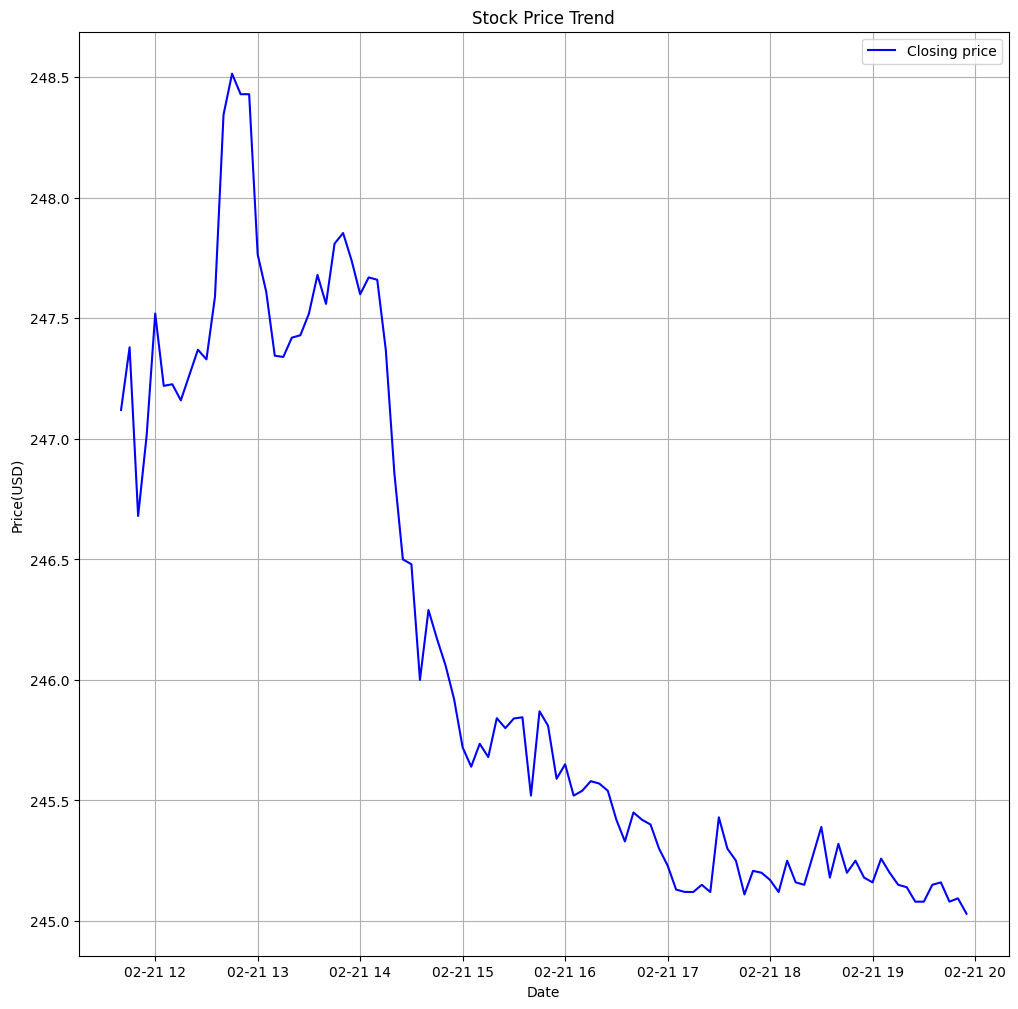

In [46]:
#Analyzing and Visualizing the Stock Trends
#1. Visualizing stock prices over time(trend line)
#y-axis: closing price of stock, x-axis: timestamps
import matplotlib.pyplot as plt
#convert the index(timestamps) to datetime format for easier plotting
df.index = pd.to_datetime(df.index)
#plot the closing prices over time
plt.figure(figsize =(12,12))
plt.plot(df.index, df['close'], label='Closing price', color='blue')
plt.title('Stock Price Trend')
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.legend()
plt.grid(True)
plt.show()


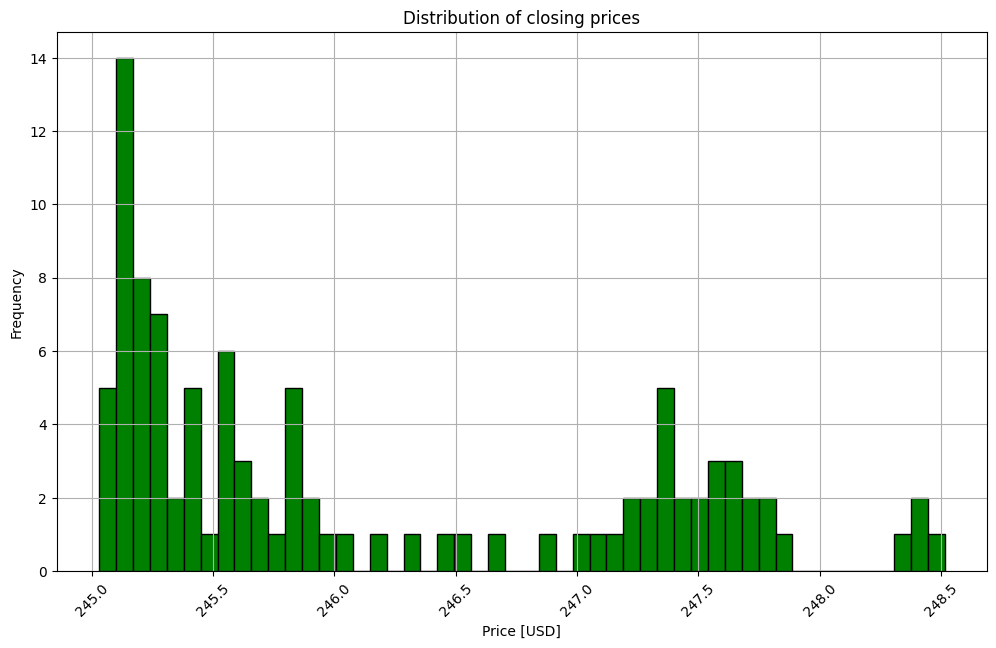

In [47]:
#analyzing the distribution of stock prices:
#plot a histogram of the closing prices
plt.figure(figsize = (12,7))
plt.hist(df['close'], bins=50, color = 'green',edgecolor='black')
plt.title('Distribution of closing prices')
plt.xticks(rotation=45)
plt.xlabel('Price [USD]')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

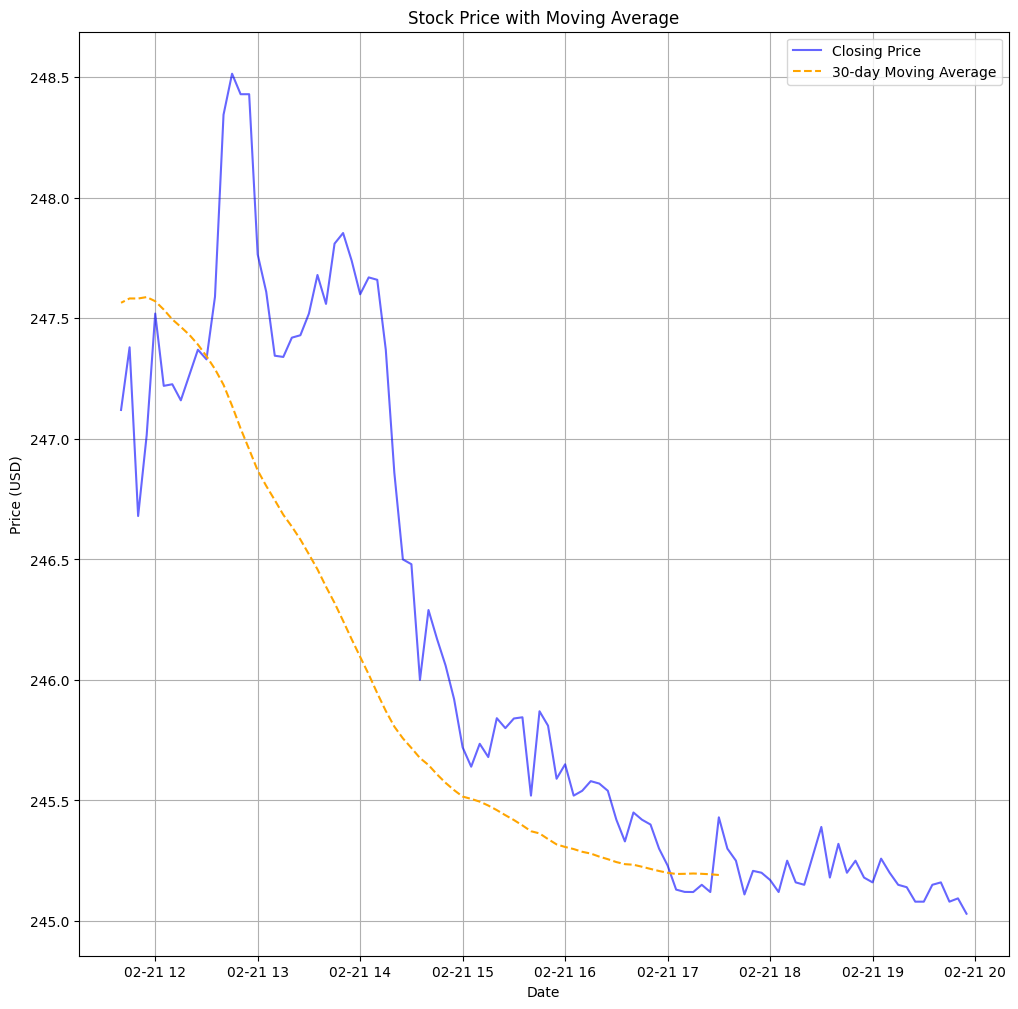

In [48]:
#Moving Average Trend (Smoothing)
df['SMA_30'] = df['close'].rolling(window=30).mean()
#plot the closing prices and the moving average
plt.figure(figsize=(12,12))
plt.plot(df.index, df['close'], label='Closing Price',color='blue', alpha=0.6)
plt.plot(df.index, df['SMA_30'], label='30-day Moving Average', color='orange', linestyle='--')
plt.title('Stock Price with Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

open           object
high           object
low            object
close         float64
volume         object
SMA_30        float64
pct_change    float64
dtype: object
open           object
high           object
low            object
close         float64
volume         object
SMA_30        float64
pct_change    float64
dtype: object


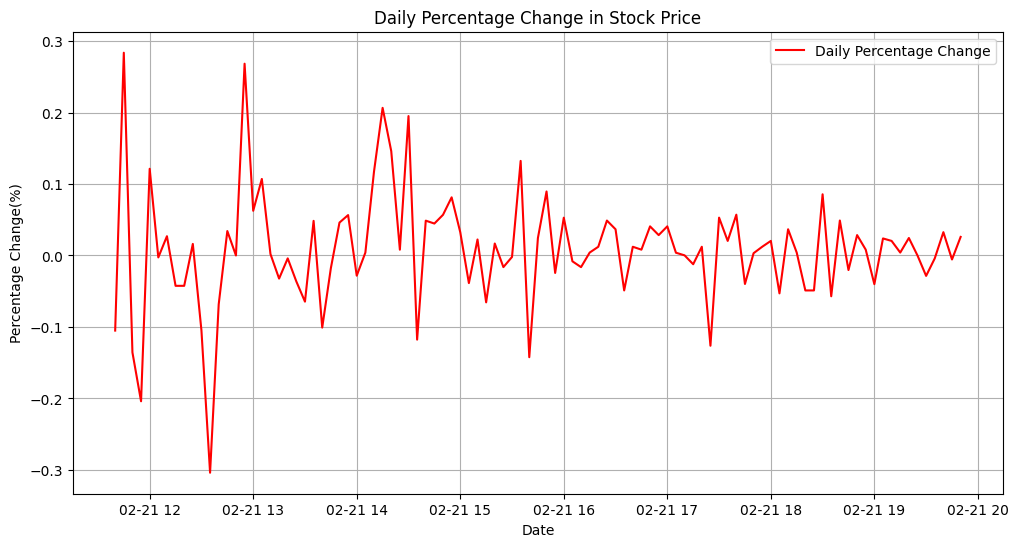

In [49]:
#volatility analysis (stock price fluctuations
#we can measure how volatile the stock is by calculating the daily percentage change and plotting that.
# Calculate the daily percentage change of the closing price
print(df.dtypes)
#conver the 'close' column to numeric, forcing any non-numeric values to Nan
df['close']=pd.to_numeric(df['close'],errors='coerce')
#now calculate the daily percentage change of the closing price
df['pct_change'] = df['close'].pct_change()*100
#check the data types again
print(df.dtypes)
#plot the daily percentage change
plt.figure(figsize=(12,6))
plt.plot(df.index, df['pct_change'],label='Daily Percentage Change', color='red')
plt.title('Daily Percentage Change in Stock Price')
plt.xlabel('Date')
plt.ylabel('Percentage Change(%)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#step 5: Scheduling and automating the data pipeline
import schedule
import time
def etl_job():
    print("Starting the ETL job...")
    #step 1: Extract data from alpha vantage
    data = fetch_stock_data()
    #step 2: Clean and transform the data
    cleaned_df = clean_stock_data(data)
    #step 3: load the cleaned data into postgresql
    load_data_to_postgres(cleaned_df)

    print("ETL job completed.")
schedule.every(5).minutes.do(etl_job)
print("Scheduler is running. Press Ctrl+C to exit.")

#continously run the scheduler
while True:
    schedule.run_pending()
    time.sleep(1)

Scheduler is running. Prece Ctrl+C to exit.
Starting the ETL job...
{'Meta Data': {'1. Information': 'Intraday (5min) open, high, low, close prices and volume', '2. Symbol': 'AAPL', '3. Last Refreshed': '2025-02-21 19:55:00', '4. Interval': '5min', '5. Output Size': 'Compact', '6. Time Zone': 'US/Eastern'}, 'Time Series (5min)': {'2025-02-21 19:55:00': {'1. open': '245.0200', '2. high': '245.1000', '3. low': '245.0000', '4. close': '245.0300', '5. volume': '3692'}, '2025-02-21 19:50:00': {'1. open': '245.1000', '2. high': '245.1100', '3. low': '245.0000', '4. close': '245.0937', '5. volume': '2064'}, '2025-02-21 19:45:00': {'1. open': '245.1500', '2. high': '245.1500', '3. low': '245.0800', '4. close': '245.0800', '5. volume': '1043'}, '2025-02-21 19:40:00': {'1. open': '245.1600', '2. high': '245.1600', '3. low': '245.0937', '4. close': '245.1600', '5. volume': '1662'}, '2025-02-21 19:35:00': {'1. open': '245.1000', '2. high': '245.1975', '3. low': '245.0900', '4. close': '245.1500', 

ConnectionError: HTTPSConnectionPool(host='www.alphavantage.co', port=443): Max retries exceeded with url: /query?function=TIME_SERIES_INTRADAY&symbol=AAPL&interval=5min&apikey=9O2H41A7VIY1QDHC (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001763A3AF170>: Failed to establish a new connection: [WinError 10051] A socket operation was attempted to an unreachable network'))